# 5. Heteroscedasticity

In [1]:
suppressPackageStartupMessages({
  library(tidyverse)
  library(tidymodels)
  library(readxl)
  library(multcomp)
  library(car)
  library(lmtest)
  library(sandwich)
})

In [2]:
df <- read_excel("data/Table5_1.xls")
head(df)

state,abortion,religion,price,laws,funds,educ,income,picket,lnabortion
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MISSISSIPPI,12.4,38.0,256,0,0,64.3,14082,100,2.517696
NEW_MEXICO,17.7,44.7,332,0,0,75.1,15458,20,2.873565
UTAH,9.3,76.7,298,1,0,85.1,15573,0,2.230014
WEST_VIRGINIA,7.7,9.8,251,0,1,66.0,15598,50,2.041220
ARKANSAS,13.5,30.0,248,1,0,66.3,15635,33,2.602690
LOUISIANA,13.4,50.9,228,1,0,68.3,15931,60,2.595255


Abortion rate  
State = name of the state (50 US states).  
ABR = Abortion rate, number of abortions per thousand women aged 15–44 in
1992.  
Religion = the percent of a state’s population that is Catholic, Southern Baptist,
Evangelical, or Mormon.  
Price = the average price charged in 1993 in non-hospital facilities for an abortion at 10 weeks with local anesthesia (weighted by the number of abortions
performed in 1992).  
Laws = a variable that takes the value of 1 if a state enforces a law that restricts a
minor’s access to abortion, 0 otherwise.  
Funds = a variable that takes the value of 1 if state funds are available for use to
pay for an abortion under most circumstances, 0 otherwise.  
Educ = the percent of a state’s population that is 25 years or older with a high
school degree (or equivalent), 1990.  
Income = disposable income per capita, 1992.  
Picket = the percentage of respondents that reported experiencing picketing
with physical contact or blocking of patients.  

In [3]:
model <- lm(abortion ~ religion + price + laws + funds + educ + income + picket, data =df)
tidy(model)
glance(model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),14.283957280,1.507763e+01,0.9473609,3.488740e-01
religion,0.020070901,8.638054e-02,0.2323544,8.173913e-01
price,-0.042363106,2.222320e-02,-1.9062555,6.347505e-02
laws,-0.873101786,2.376566e+00,-0.3673795,7.151807e-01
funds,2.820003024,2.783475e+00,1.0131233,3.168024e-01
educ,-0.287255121,1.995545e-01,-1.4394818,1.574261e-01
income,0.002400682,4.551884e-04,5.2740410,4.354736e-06
picket,-0.116871214,4.217986e-02,-2.7707823,8.295326e-03


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.5774263,0.5069973,7.062582,8.198706,2.847197e-06,7,-164.3286,346.6572,363.8655,2094.962,42,50


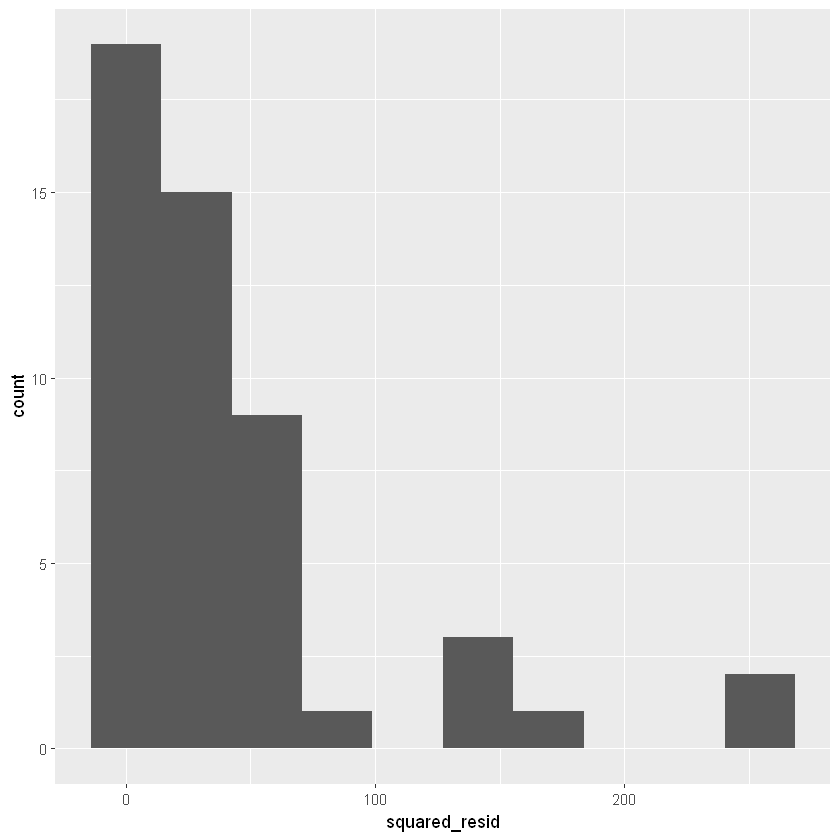

In [4]:
data <-augment(model)
data <- data |> 
mutate(squared_resid = .resid^2)
data |>
ggplot(aes(x = squared_resid)) +
geom_histogram(bins  = 10)

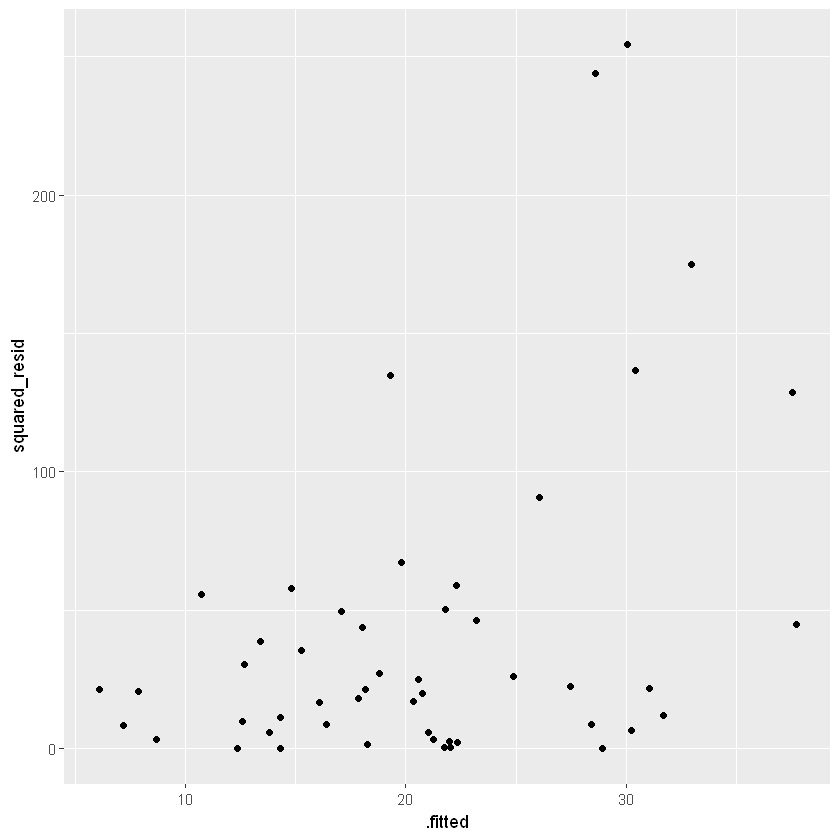

In [5]:
ggplot(data, aes(x = .fitted, y = squared_resid))+
geom_point()

## Breusch–Pagan (BP) test

In [6]:
bptest(model, studentize = TRUE, data = df)


	studentized Breusch-Pagan test

data:  model
BP = 16.001, df = 7, p-value = 0.02511


## White test

In [7]:
white_test_result <- bptest(model, ~ religion + price + laws + funds + educ + income + picket + I(religion^2) + I(price^2) + I(laws^2) + I(funds^2) + I(educ^2) + I(income^2) + I(picket^2) +
                            religion:price + religion:laws + religion:funds + religion:educ + religion:income + 
                            religion:picket + price:laws + price:funds + price:educ + price:income + price:picket + laws:funds + 
                            laws:educ + laws:income + laws:picket + funds:educ + funds:income + funds:picket + educ:income + educ:picket + income:picket, 
                            data = df)

# Print the test results
print(white_test_result)

# Check if we reject the null hypothesis of homoscedasticity
if (white_test_result$p.value < 0.05) {
  cat("Reject the null hypothesis of homoscedasticity. The model suffers from heteroscedasticity.\n")
} else {
  cat("Do not reject the null hypothesis of homoscedasticity. The model does not suffer from heteroscedasticity.\n")
}


	studentized Breusch-Pagan test

data:  model
BP = 32.102, df = 33, p-value = 0.5116

Do not reject the null hypothesis of homoscedasticity. The model does not suffer from heteroscedasticity.


## Abridged white test

In [8]:
data <- augment(model)
data <- data |>
    mutate(squared_resid = .resid^2)

In [9]:
model2 <- lm(squared_resid ~ .fitted + I(.fitted^2), data = data)
tidy(model2)
glance(model2)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),20.2023995,49.030794,0.4120349,0.6821871
.fitted,-1.4552665,4.759941,-0.3057321,0.7611587
I(.fitted^2),0.1074319,0.107890,0.9957548,0.3244684


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.1930826,0.1587457,53.13374,5.623181,0.006463723,2,-268.0407,544.0813,551.7294,132690.2,47,50


p value for F = 0.006463723, we suffer from heteroscedasticity

In [10]:
df <- read_excel("data/Table5_1.xls")
model <- lm(abortion ~ religion + price + laws + funds + educ + income + picket, data =df)

fitted_values <- fitted(model)

df_transformed <- df

df_transformed <- df_transformed %>%
  mutate(across(where(is.numeric), ~ ./fitted_values))


model2 <- lm(abortion ~ religion + price + laws + funds + 
             educ + income + picket, data = df_transformed)
tidy(model2)
glance(model2)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.8973606106,0.786093091,1.14154497,0.2601101
religion,0.0480774987,0.075204771,0.63928788,0.5261073
price,-0.0134525362,0.037889433,-0.35504717,0.7243310
laws,-0.5879502539,2.179388159,-0.26977767,0.7886524
funds,0.1956207473,3.709311583,0.05273775,0.9581909
educ,0.0288684135,0.174382545,0.16554646,0.8693082
income,0.0000652594,0.002101188,0.03105833,0.9753701
picket,0.0223771929,0.084639962,0.26438094,0.7927795


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.07414331,-0.08016613,0.3473963,0.4804846,0.8432493,7,-13.72363,45.44726,62.65547,5.068735,42,50


In [11]:
bptest(model2)


	studentized Breusch-Pagan test

data:  model2
BP = 12.679, df = 7, p-value = 0.08034


In [12]:
model3 <- lm( lnabortion ~ religion + price + laws + funds + educ + income + picket, data = df)
tidy(model3)
glance(model3)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2.8332642773,7.552630e-01,3.7513612,5.328625e-04
religion,0.0004575404,4.326942e-03,0.1057422,9.162903e-01
price,-0.0031121205,1.113196e-03,-2.7956615,7.776827e-03
laws,-0.0128839175,1.190461e-01,-0.1082263,9.143316e-01
funds,0.0876876479,1.394288e-01,0.6289064,5.328161e-01
educ,-0.0144883794,9.996011e-03,-1.4494161,1.546477e-01
income,0.0001264777,2.280113e-05,5.5469947,1.775782e-06
picket,-0.0065152887,2.112858e-03,-3.0836379,3.606917e-03


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.5891796,0.5207096,0.3537762,8.604923,1.649353e-06,7,-14.63355,47.26711,64.47531,5.256619,42,50


if price goes up by a dollar, the relative
change in the abortion rate is –0.003 or about –0.3%

In [13]:
bptest(model3)


	studentized Breusch-Pagan test

data:  model3
BP = 7.95, df = 7, p-value = 0.337


## White Robust standard errors

In [14]:
robust_se <-coeftest(model, vcov = vcovHC(model, type = "HC0"))
summary(robust_se)

    Estimate          Std. Error           t value           Pr(>|t|)        
 Min.   :-0.87310   Min.   : 0.000468   Min.   :-3.1548   Min.   :0.0000069  
 1st Qu.:-0.15947   1st Qu.: 0.033729   1st Qu.:-1.7763   1st Qu.:0.0622757  
 Median :-0.01998   Median : 0.119371   Median :-0.1347   Median :0.1924175  
 Mean   : 1.97585   Mean   : 2.304262   Mean   : 0.0245   Mean   :0.2735694  
 3rd Qu.: 0.72005   3rd Qu.: 1.942125   3rd Qu.: 1.0086   3rd Qu.:0.3932858  
 Max.   :14.28396   Max.   :13.657414   Max.   : 5.1341   Max.   :0.7952640  

In [15]:
tidy(robust_se)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),14.283957280,1.365741e+01,1.0458757,3.016005e-01
religion,0.020070901,7.686001e-02,0.2611358,7.952640e-01
price,-0.042363106,2.377806e-02,-1.7816051,8.204549e-02
laws,-0.873101786,1.645923e+00,-0.5304633,5.985845e-01
funds,2.820003024,2.830730e+00,0.9962106,3.248529e-01
educ,-0.287255121,1.618822e-01,-1.7744696,8.323437e-02
income,0.002400682,4.675923e-04,5.1341349,6.879939e-06
picket,-0.116871214,3.704561e-02,-3.1547927,2.966278e-03


In [16]:
glance(robust_se)

Original model not retained as part of coeftest object. For additional model summary information (r.squared, df, etc.), consider passing `glance.coeftest()` an object where the underlying model has been saved, i.e.`lmtest::coeftest(..., save = TRUE)`.
This message is displayed once per session.


logLik,AIC,BIC,nobs
<chr>,<dbl>,<dbl>,<int>
-164.329,346.6572,363.8655,50


In [17]:
df2 <- read_excel("data/Table1_1.xls")
head(df2)

obs,wage,female,nonwhite,union,education,exper,age,wind,femalenonw,lnwage,education_exper,_Ifemale_1,_IfemXeduca_1,_IfemXexper_1,_Inonwhite_1,_InonXeduca_1
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,11.55,1,0,0,12,20,38,1,0,2.446686,240,1,12,20,0,0
2,5.00,0,0,0,9,9,24,0,0,1.609438,81,0,0,0,0,0
3,12.00,0,0,0,16,15,37,1,0,2.484907,240,0,0,0,0,0
4,7.00,0,1,1,14,38,58,0,0,1.945910,532,0,0,0,1,14
5,21.15,1,1,0,16,19,41,1,1,3.051640,304,1,16,19,1,16
6,6.92,1,0,0,12,4,22,1,0,1.934416,48,1,12,4,0,0


In [18]:
model4 <- lm(wage ~ female + nonwhite + union + education + exper, data = df2)
tidy(model4)
glance(model4)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-7.1833382,1.01578786,-7.071691,2.508276e-12
female,-3.0748754,0.36461621,-8.433184,8.939423e-17
nonwhite,-1.5653133,0.50918754,-3.074139,2.155664e-03
union,1.0959758,0.50607809,2.165626,3.052356e-02
education,1.3703010,0.06590421,20.792312,5.507613e-83
exper,0.1666065,0.01604756,10.382050,2.659960e-24


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.3233388,0.3207018,6.508137,122.6149,3.453151e-106,5,-4240.37,8494.741,8530.872,54342.54,1283,1289


In [19]:
bptest(model4)


	studentized Breusch-Pagan test

data:  model4
BP = 55.327, df = 5, p-value = 1.118e-10


In [20]:
model5 <- coeftest(model, vcov = vcovHC(model, type = "HC0"))
tidy(model5)
glance(model5)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),14.283957280,1.365741e+01,1.0458757,3.016005e-01
religion,0.020070901,7.686001e-02,0.2611358,7.952640e-01
price,-0.042363106,2.377806e-02,-1.7816051,8.204549e-02
laws,-0.873101786,1.645923e+00,-0.5304633,5.985845e-01
funds,2.820003024,2.830730e+00,0.9962106,3.248529e-01
educ,-0.287255121,1.618822e-01,-1.7744696,8.323437e-02
income,0.002400682,4.675923e-04,5.1341349,6.879939e-06
picket,-0.116871214,3.704561e-02,-3.1547927,2.966278e-03


logLik,AIC,BIC,nobs
<chr>,<dbl>,<dbl>,<int>
-164.329,346.6572,363.8655,50


## Exercises

🚧 Under Construction